In [1]:
import copy
import numpy as np
import numpy.ma as ma
from scipy.io import netcdf as nc
from scipy.interpolate import griddata
from scipy import stats
import netCDF4 as nc4
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import numba
from numba import njit
import time
import sys
import altair as alt
import glob
import os
import matplotlib.animation as animation
from IPython.display import HTML

### Options

In [2]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 166
nlat = 46
nlon = 72

### Pre-defined normal functions

In [22]:
# Return harvest rate and natural PFT fraction from upscaled 4x5 harvest rate data
def retrieve_hrvrate(fpath, area_4x5, denflag=0, getmask=True, hr_lev=0.0):
    nclu=nc4.Dataset(fpath)
    prif_hv = nclu['HARVEST_VH1'][:]
    prin_hv = nclu['HARVEST_VH2'][:]
    secmf_hv = nclu['HARVEST_SH1'][:]
    secyf_hv = nclu['HARVEST_SH2'][:]
    secn_hv = nclu['HARVEST_SH3'][:]
    pct_nat_pft = nclu['PCT_NAT_PFT'][:]
    nclu.close()

    # Transfer into per m2 density value
    if(denflag == 1):
        prif_hv_den = prif_hv / (area_4x5*1e6)
        prin_hv_den = prin_hv / (area_4x5*1e6)
        secmf_hv_den = secmf_hv / (area_4x5*1e6)
        secyf_hv_den = secyf_hv / (area_4x5*1e6)
        secn_hv_den = secn_hv / (area_4x5*1e6)

        # Aggregate the number to certain year
        luh2_pri_hv = np.sum(prif_hv_den[:, :, :], 0) + np.sum(prin_hv_den[:, :, :], 0)
        luh2_sec_m_hv = np.sum(secmf_hv_den[:, :, :], 0)
        luh2_sec_y_hv = np.sum(secyf_hv_den[:, :, :], 0) + np.sum(secn_hv_den[:, :, :], 0)
        luh2_tot_hv = luh2_pri_hv + luh2_pri_hv + luh2_sec_y_hv
    else:   
        # Aggregate the harvest amount
        luh2_pri_hv = prif_hv + prin_hv
        luh2_sec_m_hv = secmf_hv
        luh2_sec_y_hv = secyf_hv + secn_hv
        luh2_tot_hv = prif_hv + prin_hv + secmf_hv + secyf_hv + secn_hv

    if(getmask):
        # mask value 1.0 represents nan
        pri_mask = copy.deepcopy(luh2_pri_hv)
        pri_mask[pri_mask>hr_lev] = -1.0
        pri_mask = pri_mask + 1.0
        luh2_pri_hv.mask = pri_mask
    
        secm_mask = copy.deepcopy(luh2_sec_m_hv)
        secm_mask[secm_mask>hr_lev] = -1.0
        secm_mask = secm_mask + 1.0
        luh2_sec_m_hv.mask = secm_mask
    
        secy_mask = copy.deepcopy(luh2_sec_y_hv)
        secy_mask[secy_mask>hr_lev] = -1.0
        secy_mask = secy_mask + 1.0
        luh2_sec_y_hv.mask = secy_mask
    
        tothrv_mask = copy.deepcopy(luh2_tot_hv)
        tothrv_mask[tothrv_mask>hr_lev] = -1.0
        tothrv_mask = tothrv_mask + 1.0
        luh2_tot_hv.mask = tothrv_mask

    # Crop and bareground fraction
    pct_crop = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),15,:,:])
    pct_bg = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),0,:,:])
    pct_nat = 100.0 - pct_crop - pct_bg
    
    return luh2_pri_hv, luh2_sec_m_hv, luh2_sec_y_hv, luh2_tot_hv, pct_nat

# Only retreive secondary forest area time series
# Can return the secondary forest fraction and grid area time series if set verbose_output to True
def retrieve_secfrac_luh2(fpath, verbose_output=False):
    nclu=nc4.Dataset(fpath)
    secf_luh2 = nclu['secdf'][:]
    secn_luh2 = nclu['secdn'][:]
    lat_luh2 = nclu['lat'][:]
    lon_luh2 = nclu['lon'][:]
    nclu.close()

    # Global grid area for 0.25 deg for LUH2 datasets
    nlon_loc = 1440
    nlat_loc = 720
    grid_area = np.ones((nlat_loc, nlon_loc))*-9999.
    earth_area = 5.096e14
    lat = np.arange(-89.875, 90.125, 0.25)
    res = 0.25;
    for i in np.arange(0,nlat_loc):
        for j in np.arange(0,nlon_loc):
            grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                        np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
    
    sec_tot = secf_luh2+secn_luh2
    sec_tot[secf_luh2<=0.0] = np.float('nan')
    seca_luh2 = copy.deepcopy(sec_tot[(1165-nyr):1165,:,:])
    for i in np.arange(0,nyr):
        seca_luh2[i,:,:] = sec_tot[(1165-nyr+i),:,:] * grid_area
    # m2 to km2
    seca_luh2_tot = np.nansum(np.nansum(seca_luh2, 1), 1)/1e6
    
    if(verbose_output):
        return seca_luh2_tot, sec_tot, grid_area
    else:
        return seca_luh2_tot

def plot_all_cases(modname, sel_yr, varlist, set_levels, set_ticks, set_unit_tag, save_path, savefig = False):
    # Plot 4 x 3
    # Define the figure and each axis for the 4 rows and 3 columns
    fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(24,16))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    # Subplot of all cases 
    for i in np.arange(0, len(modname)):
        # Contour plot
        cs=axs[i].contourf(lonnc, latnc, varlist[i][:,:], levels=set_levels, \
                       transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(modname[i], fontsize=32)

        # Draw the coastines for each subplot
        axs[i].coastlines()
    
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
        gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', spacing='proportional', 
                  extend='both', ticks = set_ticks)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.05, 0.1, set_unit_tag, fontsize=28)
    # plt.tight_layout()
    if(savefig):
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
    
def plot_logging_cases(modname, sel_yr, varlist, set_levels, set_ticks, set_unit_tag, save_path, savefig = False):
    # Plot 2 x 4
    # Define the figure and each axis for the 4 rows and 3 columns
    fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,20))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    # Subplot of all cases 
    for i in np.arange(0, len(modname)):
        # Contour plot
        cs=axs[i].contourf(lonnc, latnc, varlist[i][:,:], levels=set_levels, \
                       transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(modname[i], fontsize=32)

        # Draw the coastines for each subplot
        axs[i].coastlines()
    
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
        gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', spacing='proportional', 
                  extend='both', ticks = set_ticks)
#     cbar.set_ticklabels(['-1%', '-0.75%', '-0.5%', '-0.25%', '0', '0.25%', '0.5%', '0.75%', '1%'])
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.05, 0.1, set_unit_tag, fontsize=28)
    # plt.tight_layout()
    if(savefig):
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
    return [fig, axs]

# Obtain the logging impact either in the original unit or in the percentage
# Weights shall be multiplied with the corresponding variables before calling 
# and shall be divided by the return value (if in the original unit) after 
# calling the function. 
def obtain_logging_impact(modname, varlist, sel_yr, output_ratio = False):
    var_diff = []
    var_logging_global = []
    var_diff_deno = []
    var_logging_global_deno = []
    for i in np.arange(0, case_len):
        # Contour plot
        count = len(sel_yr)
        if (count > 1):
            begidx = sel_yr[0]
            endidx = sel_yr[count - 1]
            if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
                if(modname[i][4:5] == 'c'):
                    if(modname[i] != 'har_c'):
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[i+1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
                    else:
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
                else:
                    if(modname[i][4:5] == 'a'):
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[i-1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
        else:
            if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
                if(modname[i][4:5] == 'c'):
                    if(modname[i] != 'har_c'):
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[i+1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
                    else:
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
                else:
                    if(modname[i][4:5] == 'a'):
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[i-1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_diff[i], 0), 0))
        var_logging_global_deno.append(np.nanmean(np.nanmean(var_diff_deno[i], 0), 0))
    if(output_ratio):
        global_total = 100.0 * np.array(var_logging_global)/np.array(var_logging_global_deno)
    else:
        global_total = np.array(var_logging_global)
    return [var_diff, global_total]

# Time series of the logging impact
# Use the January output from with and without case to perform diff
def obtain_logging_impact_ts(modname, varlist, output_ratio = False):
    var_logging = []
    var_logging_global = []
    var_logging_deno = []
    var_logging_global_deno = []
    idx = 0
    nyr = 165
    for i in np.arange(0, case_len):
        var_logging_deno.append(varlist[i][idx:12*nyr+idx:12,:,:])
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                var_logging.append(varlist[i][idx:12*nyr+idx:12,:,:] - varlist[i+1][idx:12*nyr+idx:12,:,:])
            else:
                var_logging.append(varlist[i][idx:12*nyr+idx:12,:,:] - varlist[1][idx:12*nyr+idx:12,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                var_logging.append(varlist[i][idx:12*nyr+idx:12,:,:] - varlist[i-1][idx:12*nyr+idx:12,:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_logging[i][:,:,:], 1), 1))
        var_logging_global_deno.append(np.nanmean(np.nanmean(var_logging_deno[i][:,:,:], 1), 1))
    if(output_ratio):
        var_logging_r = 100.0 * np.array(var_logging_global)/np.array(var_logging_global_deno)
    else:
        var_logging_r = 0.0
    return [var_logging, var_logging_global, var_logging_r]

# Direct impact is calculated by subtracting the variable values after logging (Feb) from before the logging (Jan) 
def obtain_dir_logging_impact_ts(modname, varlist, begyr, endyr, weighted = True, output_ratio = False):
    var_logging = []
    var_logging_loss = []
    # Impact due to climate variation
    var_logging_var = []
    # Baseline value for calculating ratio
    var_logging_deno = []
    # Global aggregation
    var_logging_global = []
    var_logging_global_deno = []
    begidx_aft = 12*begyr+1
    endidx_aft = 12*endyr+1
    begidx_bef = 12*begyr
    endidx_bef = 12*endyr
    # Weighted average require the pre-defined area_4x5.
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            # Direct loss (Wt_Feb - Wt_Jan) and denominator
            if(weighted):
                temp_array = varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:]
                temp_array[temp_array<-2e-1] = np.nan
                temp_array[temp_array>2e-1] = np.nan
                var_logging_loss.append(area_4x5[None,:,:] * copy.deepcopy(temp_array))
                var_logging_deno.append(area_4x5[None,:,:] * varlist[i][begidx_aft:endidx_aft:12,:,:])
            else:
                temp_array = varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:]
                temp_array[temp_array<-2e-1] = np.nan
                temp_array[temp_array>2e-1] = np.nan
                var_logging_loss.append(copy.deepcopy(temp_array))
                var_logging_deno.append(varlist[i][begidx_aft:endidx_aft:12,:,:])
            # Variation (Wot_Feb - Wot_Jan)
            if(modname[i][4:5] == 'c'):
                if(modname[i] != 'har_c'):
                    if(weighted):
                        temp_array = varlist[i+1][begidx_aft:endidx_aft:12,:,:] - varlist[i+1][begidx_bef:endidx_bef:12,:,:]
                    else:
                        temp_array = varlist[i+1][begidx_aft:endidx_aft:12,:,:] - varlist[i+1][begidx_bef:endidx_bef:12,:,:]
                else:
                    if(weighted):
                        temp_array = varlist[1][begidx_aft:endidx_aft:12,:,:] - varlist[1][begidx_bef:endidx_bef:12,:,:]
                    else:
                        temp_array = varlist[1][begidx_aft:endidx_aft:12,:,:] - varlist[1][begidx_bef:endidx_bef:12,:,:]
            else:
                if(modname[i][4:5] == 'a'):
                    temp_array = varlist[i-1][begidx_aft:endidx_aft:12,:,:] - varlist[i-1][begidx_bef:endidx_bef:12,:,:]
            temp_array[temp_array<-2e-1] = np.nan
            temp_array[temp_array>2e-1] = np.nan
            if(weighted):
                var_logging_var.append(area_4x5[None,:,:] * copy.deepcopy(temp_array))
            else:                        
                var_logging_var.append(copy.deepcopy(temp_array))
    for i in np.arange(0,len(modname_hrv)):
        var_logging.append(var_logging_loss[i])# - var_logging_var[i])
        #var_logging.append(var_logging_var[i])
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_logging[i], 1), 1))
        var_logging_global_deno.append(np.nanmean(np.nanmean(var_logging_deno[i], 1), 1))
    if(output_ratio):
        var_logging_ratio = 100.0 * np.array(var_logging_global)/np.array(var_logging_global_deno)# - var_logging_var[i])
    else:
        var_logging_ratio = 0.0

    return [var_logging, var_logging_global, var_logging_ratio]

# Change of variables due to natural + CO2 fertilization
# Can accept either a consecutive sequence of months [begmonth, endmonth] or a single month
def obtain_regrowth_ts(modname, varlist, begyr, endyr, months):
    var_regrowth = []
    var_regrowth_global = []
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            begidx_bef = 12*begyr+months[0]-1
            endidx_bef = 12*endyr+months[0]-1
            if(len(months) > 1):
                # Multiple months
                begidx_aft = 12*begyr+months[1]-1
                endidx_aft = 12*endyr+months[1]-1    
            else:
                # One month
                begidx_aft = 12*begyr+months[0]
                endidx_aft = 12*endyr+months[0]
            var_regrowth.append(varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:])        
    for i in np.arange(0, len(modname_hrv)):
        var_regrowth_global.append(np.nanmean(np.nanmean(var_regrowth[i], 1), 1))
    return [var_regrowth, var_regrowth_global]

# Regrowth from natural revovery by excluding CO2 fertilization
# The difference of Next Jan - Current Feb between with logging and without logging 
def obtain_regrowth_impact_ts(modname, varlist, begyr, endyr):
    var_regrowth = []
    var_regrowth_global = []
    var_diff_dec_jan = []
    # First calculate diff between Feb and next Jan
    begidx_bef = 12*begyr+1
    endidx_bef = 12*(endyr-1)+1
    begidx_aft = 12*begyr+12
    endidx_aft = 12*endyr
    for i in np.arange(0,case_len):
        var_diff_dec_jan.append(varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:])  
    # Difference between with and without logging
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[i+1][:,:,:])
            else:
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[i-1][:,:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_regrowth_global.append(np.nanmean(np.nanmean(var_regrowth[i], 1), 1))
    return [var_regrowth, var_regrowth_global]
        
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


### Use NetCDF4 to open dataset

In [3]:
## Get and open the history file
## Change the line below to point to the file that you've made,
start = time.time()

# Should be a concatenated monthly FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
# Global variables and switches
verbose = True
make_movie = False

filename_in = 'D:/FATES_cases/fates.har_c.1850_2015.compressed.nc'
ds = nc4.Dataset(filename_in)
    
## read in variables
## Climate
tbot = ds['TBOT'][:]
# 2m air temperature calculated from LSM
t2m = ds['TSA'][:]
fates_area_frac = ds['FATES_FRACTION'][:]

## Biogeophysics
ref_sr = ds['FSR'][:]
ref_sr_d = ds['FSRVD'][:]
ref_sr_i = ds['FSRVI'][:]
abs_sr = ds['FSA'][:]
tot_sr = ds['FSDS'][:]
tot_sr_d = ds['FSDSVD'][:]
tot_sr_i = ds['FSDSVI'][:]
tot_sh = ds['FSH'][:]
rad_err = ds['FATES_RAD_ERROR'][:]
tot_lh = ds['EFLX_LH_TOT'][:]
tot_gh = ds['FGR'][:]
# eg = ds['FGEV'][:]
eg = ds['QSOIL'][:]
# t = ds['FCTR'][:]
t = ds['QVEGT'][:]
# ec = ds['FCEV'][:]
ec = ds['QVEGE'][:]
et = eg + t + ec

## Macro-ecology
vegc = ds['FATES_VEGC'][:]
litterc = ds['LITTERC'][:]
vegc_pf = ds['FATES_VEGC_PF'][:]
area_plants = ds['FATES_AREA_PLANTS'][:]
structc = ds['FATES_STRUCTC'][:]
nonstructc = ds['FATES_NONSTRUCTC'][:]
leafc = ds['FATES_LEAFC'][:]
# C fluxes
gpp = ds['FATES_GPP'][:]
gpp_sec = ds['FATES_GPP_SECONDARY'][:]
gpp_pf = ds['FATES_GPP_PF'][:]
npp = ds['FATES_NPP'][:]
nep = ds['FATES_NEP'][:]
# nbp = ds['NBP'][:]
hr = ds['FATES_HET_RESP'][:]
litc_in = ds['FATES_LITTER_IN'][:]
litc_out = ds['FATES_LITTER_OUT'][:]
    
## Demography
# Nplant
np_pf = ds['FATES_NPLANT_PF'][:]
np_sz = ds['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = ds['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = ds['FATES_SEED_GERM_EL'][:]

# Crown area to calculate dominant PFT
cr_area_pf = ds['FATES_CROWNAREA_PF'][:]
ca_area_ap = ds['FATES_CANOPYAREA_AP'][:]
cr_area_cl = ds['FATES_CROWNAREA_CL'][:]
hite = ds['FATES_CA_WEIGHTED_HEIGHT'][:]
elai = ds['ELAI'][:]
tlai = ds['TLAI'][:]

# No-comp mode only, please comment this out if not no-comp mode result
area_pf_nocomp = ds['FATES_NOCOMP_PATCHAREA_PF'][:]
    
# LUC related
# # Requires huge memory
# # Do not read if not necessary
# hrvflux = ds['FATES_HARVEST_CARBON_FLUX'][:]
# # prod10c = ds['PROD10C'][:]
# # prod100c = ds['PROD100C'][:]
# # hrv10flux = ds['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv100flux = ds['HRV_DEADSTEMC_TO_PROD100C'][:]
hrvc = ds['FATES_WOOD_PRODUCT'][:]
hrv_debt = ds['FATES_HARVEST_DEBT'][:]
hrv_debt_sec_m = ds['FATES_HARVEST_DEBT_SEC_MATURE'][:]
hrv_debt_sec_y = ds['FATES_HARVEST_DEBT_SEC_YOUNG'][:]

# Secondary forest related (fraction and age distribution)
sec_frac = ds['FATES_SECONDARY_FOREST_FRACTION'][:]
sec_biomass = ds['FATES_VEGC_SE_PF'][:]
canopy_area_ap = ds['FATES_CANOPYAREA_AP'][:]
parea_ap = ds['FATES_PATCHAREA_AP'][:]
pfarea = ds['FATES_NOCOMP_PATCHAREA_PF'][:]
    
ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

# Open half degree land mask
filename_in_maskinput = 'halfdeg_landmask.nc'
ds = nc4.Dataset(filename_in_maskinput)
landfrac_halfdeg = ds['LANDFRAC_PFT'][:]
ds.close()

land_dot5xdot5 = copy.deepcopy(landfrac_halfdeg)
end = time.time()

print('Time elapsed: ', end - start)


('Time elapsed: ', 23.18400001525879)


C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


### Evaluation of FATES physical variables against multiple observations

In [4]:
# Open biomass observations
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = np.nanmean(tropical_for_c_tmp[:,:,:], axis=0)

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = np.nanmean(esacci_for_c_tmp[:,:,:], axis=0)

# Geo Carbon
filename_in = 'biomass_data_ilamb/geocarbon.nc'
ds = nc4.Dataset(filename_in)
geocarbon_for_c_tmp = ds.variables['biomass'][:]
ds.close()
 
geocarbon_for_c = np.nanmean(geocarbon_for_c_tmp[:,:,:], axis=0)

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
gc_lat = fin.variables['lat'][:]
gc_lon = fin.variables['lon'][:]
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = np.nanmean(gc_for_c_tmp[:,:,:], axis=0)

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = np.nanmean(nbcd2000_for_c_tmp[:,:,:], axis=0)

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = np.nanmean(usf_for_c_tmp[:,:,:], axis=0)

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = np.nanmean(thurner_for_c_tmp[:,:,:], axis=0)

# Xu-Saatchi
filename_in = 'biomass_data_ilamb/XuSaatchi.nc'
ds = nc4.Dataset(filename_in)
xusaatchi_for_c_tmp = ds.variables['biomass'][:]
ds.close()

xusaatchi_for_c = np.nanmean(xusaatchi_for_c_tmp[:,:,:], axis=0)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [5]:
# Global grid area for 0.5 deg 
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

sel_yr = 1
# Get the latitudinal mean of the forest biomass of all datasets
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates = np.sum(vegc_pf_copy[(12*nyr-1),0:12,:,:], 0)
vegc_fates_for = np.sum(vegc_pf_copy[(12*nyr-1),0:9,:,:], 0)
vegc_1 = vegc_pf_copy[(12*sel_yr-1),0,:,:]
vegc_2 = vegc_pf_copy[(12*sel_yr-1),1,:,:]
vegc_3 = vegc_pf_copy[(12*sel_yr-1),2,:,:]
vegc_4 = vegc_pf_copy[(12*sel_yr-1),3,:,:]
vegc_5 = vegc_pf_copy[(12*sel_yr-1),4,:,:]
vegc_6 = vegc_pf_copy[(12*sel_yr-1),5,:,:]
vegc_7 = vegc_pf_copy[(12*sel_yr-1),6,:,:]
vegc_8 = vegc_pf_copy[(12*sel_yr-1),7,:,:]
vegc_9 = vegc_pf_copy[(12*sel_yr-1),8,:,:]
vegc_copy = copy.deepcopy(vegc)
vegc_copy[vegc_copy>1e2] = np.float('nan')
vegc_copy[vegc_copy<0] = np.float('nan')
vegc_fates_all = vegc_copy[(12*nyr-1),:,:]

# FATES
vegc_lat = np.nanmean(vegc_fates, 1)
vegc_lat_for = np.nanmean(vegc_fates_for, 1)
vegc_all_lat = np.nanmean(vegc_fates_all, 1)
vegc_all_lat[vegc_all_lat<=0] = np.float('nan')
vegc_all_lat_tot = np.nanmean(vegc_fates_all*area_4x5/1e6, 1)
vegc_1_lat = np.nanmean(vegc_1, 1)
vegc_2_lat = np.nanmean(vegc_2, 1)
vegc_3_lat = np.nanmean(vegc_3, 1)
vegc_4_lat = np.nanmean(vegc_4, 1)
vegc_5_lat = np.nanmean(vegc_5, 1)
vegc_6_lat = np.nanmean(vegc_6, 1)
vegc_7_lat = np.nanmean(vegc_7, 1)
vegc_8_lat = np.nanmean(vegc_8, 1)
vegc_9_lat = np.nanmean(vegc_9, 1)
vegc_for_lat = vegc_1_lat + vegc_2_lat + vegc_3_lat + vegc_4_lat + vegc_5_lat + vegc_6_lat
# Do not plot the region outside observation's range
vegc_for_lat[0:10] = np.float('nan')

# Other obs
tropical_for_c_copy = copy.deepcopy(tropical_for_c)
tropical_for_c_copy[tropical_for_c_copy>1e5] = np.float('nan')
geocarbon_for_c_copy = copy.deepcopy(geocarbon_for_c)
geocarbon_for_c_copy[geocarbon_for_c_copy>1e5] = np.float('nan')
esacci_for_c_copy = copy.deepcopy(esacci_for_c)
esacci_for_c_copy[esacci_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy = copy.deepcopy(gc_for_c)
gc_for_c_copy[gc_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy[gc_for_c_copy<0] = np.float('nan')
nbcd2000_for_c_copy = copy.deepcopy(nbcd2000_for_c)
nbcd2000_for_c_copy[nbcd2000_for_c_copy>1e5] = np.float('nan')
usf_for_c_copy = copy.deepcopy(usf_for_c)
usf_for_c_copy[usf_for_c_copy>1e5] = np.float('nan')
thurner_for_c_copy = copy.deepcopy(thurner_for_c)
thurner_for_c_copy[thurner_for_c_copy>1e5] = np.float('nan')
xusaatchi_for_c_copy = copy.deepcopy(xusaatchi_for_c)
xusaatchi_for_c_copy[xusaatchi_for_c_copy>1e5] = np.float('nan')

tropical_lat = np.nanmean(tropical_for_c_copy, 1)
tropical_lat[tropical_lat<=0] = np.float('nan')
geocarbon_lat = np.nanmean(geocarbon_for_c_copy, 1)
geocarbon_lat[geocarbon_lat<=0] = np.float('nan')
esacci_lat = np.nanmean(esacci_for_c_copy, 1)
esacci_lat[esacci_lat<=0] = np.float('nan')
gc_lat = np.nanmean(gc_for_c_copy, 1)
gc_lat[gc_lat<=0] = np.float('nan')
nbcd2000_lat = np.nanmean(nbcd2000_for_c_copy, 1)
nbcd2000_lat[nbcd2000_lat<=0] = np.float('nan')
usf_lat = np.nanmean(usf_for_c_copy, 1)
usf_lat[usf_lat<=0] = np.float('nan')
thurner_lat = np.nanmean(thurner_for_c_copy, 1)
thurner_lat[thurner_lat<=0] = np.float('nan')
xusaatchi_lat = np.nanmean(xusaatchi_for_c_copy, 1)
xusaatchi_lat[xusaatchi_lat<=0] = np.float('nan')

tropical_lat_tot = np.nanmean(tropical_for_c_copy*grid_area/1e12, 1)
geocarbon_lat_tot = np.nanmean(geocarbon_for_c_copy[:,0:720]*grid_area[59:340,:]/1e12, 1)
esacci_lat_tot = np.nanmean(esacci_for_c_copy[:,0:720]*grid_area[59:340,:]/1e12, 1)
gc_lat_tot = np.nanmean(gc_for_c_copy*grid_area/1e12, 1)
nbcd2000_lat_tot = np.nanmean(nbcd2000_for_c_copy*grid_area/1e12, 1)
usf_lat_tot = np.nanmean(usf_for_c_copy*grid_area/1e12, 1)
thurner_lat_tot = np.nanmean(thurner_for_c_copy*grid_area/1e12, 1)
xusaatchi_lat_tot = np.nanmean(xusaatchi_for_c_copy*grid_area/1e12, 1)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
C:\User

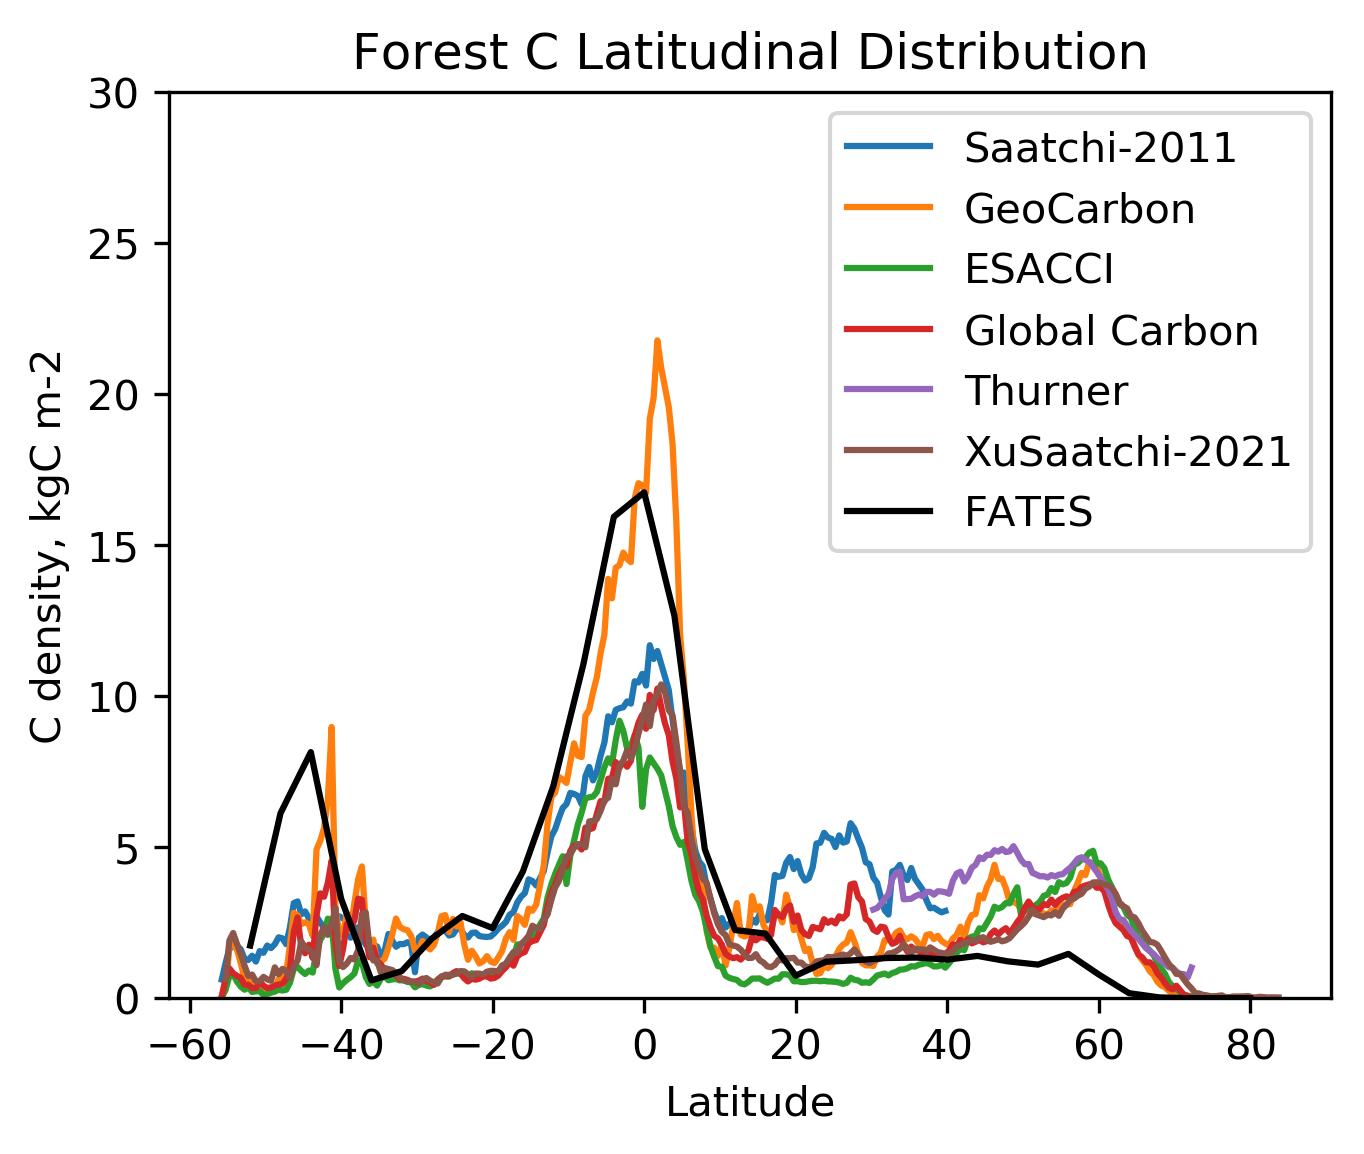

In [6]:
# Biomass C density
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
x4 = np.arange(90.25, -89.75, -0.5)
x5 = np.arange(83.75, -56.75, -0.5)
plt.plot(x1, tropical_lat)
# Here 0.1 is the transfer factor of the unit: Mg/ha -> kg/m2.
plt.plot(x5, geocarbon_lat*0.1)
plt.plot(x2, esacci_lat*0.1)
plt.plot(x1, gc_lat)
# plt.plot(x1, nbcd2000_lat)
# plt.plot(x1, usf_lat)
plt.plot(x1, thurner_lat)
plt.plot(x4, xusaatchi_lat*0.1)
plt.plot(x3, vegc_for_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Saatchi-2011', 'GeoCarbon', 'ESACCI', 'Global Carbon', 'Thurner', 'XuSaatchi-2021', 'FATES'])
plt.title('Forest C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
# plt.yscale('log')
plt.ylim([0, 30])
plt.savefig('BiomassC_den_comparison_obs.png')

In [7]:
# Open albedo observations
filename_in = 'albedo_data_ilamb/albedoCERESed4.1.nc'
ds = nc4.Dataset(filename_in)
ceres_alb_tmp = ds.variables['albedo'][:]
ds.close()

# There's some issue in the dataset: the western part of data is corrupted.
# Have to abandon this data for now
ceres_alb = np.nanmean(ceres_alb_tmp[:,:,:], axis=0)

filename_in = 'albedo_data_ilamb/albedo_0.5x0.5_GEWEX.nc'
ds = nc4.Dataset(filename_in)
gewex_alb_tmp = ds.variables['albedo'][:]
ds.close()

gewex_summer = np.zeros((72,360,720))
for i in np.arange(0,24):
    gewex_summer[3*i:3*i+3,:,:] = gewex_alb_tmp[12*i+5:12*i+8,:,:]
gewex_alb = np.nanmean(gewex_summer[:,:,:], axis=0)

In [8]:
# Global grid area for 0.5 deg 
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
alb_copy = copy.deepcopy(ref_sr[:,:,:]/(tot_sr[:,:,:] + 1e-10))
alb_all_temp = np.zeros((72,46,72))
for i in np.arange(140,164):
    alb_all_temp[3*(i-140):3*(i-140)+3,:,:] = alb_copy[12*i+5:12*i+8,:,:]
alb_all = np.nanmean(alb_all_temp[:,:,:], 0)
alb_all[alb_all>1.0] = np.float('nan')
alb_all[alb_all<0.0] = np.float('nan')
# FATES
alb_lat = np.nanmean(alb_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
gewex_alb_copy = copy.deepcopy(gewex_alb)
# mask out ocean
gewex_alb_copy[land_dot5xdot5 < 0.5] = np.float('nan')
gewex_alb_copy[gewex_alb_copy>1.0] = np.float('nan')
gewex_alb_copy[gewex_alb_copy<0.0] = np.float('nan')

gewex_alb_lat = np.nanmean(gewex_alb_copy, 1)
gewex_alb_lat[gewex_alb_lat<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal


In [ ]:
# Albedo
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
x3 = np.arange(89.75, -90.25, -0.5)
plt.plot(x1, gewex_alb_lat)
plt.plot(x2, alb_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['GEWEX', 'FATES'])
plt.title('Summert-time (JJA) albedo latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('Albedo, 0 - 1')
plt.xlim([-60, 90])
plt.ylim([0, 1])
plt.savefig('Albedo_comparison_obs.png')

In [9]:
# Open LAI observations
filename_in = 'lai_data_ilamb/lai_0.5x0.5_avhrr.nc'
ds = nc4.Dataset(filename_in)
avhrr_lai_tmp = ds.variables['lai'][:]
ds.close()

avhrr_lai = np.nanmean(avhrr_lai_tmp[:,:,:], axis=0)

filename_in = 'lai_data_ilamb/lai_0.5x0.5_modis.nc'
ds = nc4.Dataset(filename_in)
modis_lai_tmp = ds.variables['lai'][:]
ds.close()

modis_lai = np.nanmean(modis_lai_tmp[:,:,:], axis=0)

filename_in = 'lai_data_ilamb/lai_avh15c1.nc'
ds = nc4.Dataset(filename_in)
avh15c1_lai_tmp = ds.variables['lai'][:]
ds.close()

avh15c1_lai = np.nanmean(avh15c1_lai_tmp[:,:,:], axis=0)


In [10]:
sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
lai_copy = copy.deepcopy(tlai[:,:,:])
lai_all_temp = np.zeros((72,46,72))
for i in np.arange(140,164):
    lai_all_temp[3*(i-140):3*(i-140)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
lai_all_temp[lai_all_temp>20.0] = np.float('nan')
lai_all = np.nanmean(lai_all_temp[:,:,:], 0)
# FATES
lai_lat = np.nanmean(lai_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
avhrr_lai_copy = copy.deepcopy(avhrr_lai)
avhrr_lai_lat = np.nanmean(avhrr_lai_copy, 1)
avhrr_lai_lat[avhrr_lai_lat<=0] = np.float('nan')

modis_lai_copy = copy.deepcopy(modis_lai)
modis_lai_lat = np.nanmean(modis_lai_copy, 1)
modis_lai_lat[modis_lai_lat<=0] = np.float('nan')

avh15c1_lai_copy = copy.deepcopy(avh15c1_lai)
avh15c1_lai_lat = np.nanmean(avh15c1_lai_copy, 1)
avh15c1_lai_lat[avhrr_lai_lat<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal


In [ ]:
# LAI
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, avhrr_lai_lat)
plt.plot(x1, modis_lai_lat)
plt.plot(x1, avh15c1_lai_lat)
plt.plot(x2, lai_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['AVHRR', 'MODIS', 'AVH15C1', 'FATES'])
plt.title('LAI latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('Summer-time Leaf Area Index, m2 m-2')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('LAI_comparison_obs.png')

In [11]:
# Open GPP observations
filename_in = 'gpp_data_ilamb/gpp_fluxcom.nc'
ds = nc4.Dataset(filename_in)
fluxcom_gpp_tmp = ds.variables['gpp'][:]
ds.close()

fluxcom_gpp = np.nanmean(fluxcom_gpp_tmp[:,:], axis=0)

filename_in = 'gpp_data_ilamb/gpp_fluxnet2015.nc'
ds = nc4.Dataset(filename_in)
fluxnet2015_gpp_tmp = ds.variables['gpp'][:]
ds.close()

fluxnet2015_gpp = copy.deepcopy(fluxnet2015_gpp_tmp[:,:])

filename_in = 'gpp_data_ilamb/gpp_wecann.nc'
ds = nc4.Dataset(filename_in)
wecann_gpp_tmp = ds.variables['gpp'][:]
ds.close()

wecann_gpp = np.nanmean(wecann_gpp_tmp[:,:,:], axis=0)

In [12]:
sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
gpp_copy = copy.deepcopy(gpp[:,:,:])
# gpp_all_temp = np.zeros((72,46,72))
# for i in np.arange(140,164):
#     lai_all_temp[3*(i-140):3*(i-140)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
# gpp_all_temp[lai_all_temp>20.0] = np.float('nan')
gpp_all = np.nanmean(gpp_copy[:,:,:], 0)
# FATES
gpp_lat = np.nanmean(gpp_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
fluxcom_gpp_copy = copy.deepcopy(fluxcom_gpp)
fluxcom_gpp_lat = np.nanmean(fluxcom_gpp_copy, 1)
fluxcom_gpp_lat[fluxcom_gpp_lat<=0] = np.float('nan')

# There's some problem with this dataset
fluxnet2015_gpp_copy = copy.deepcopy(fluxnet2015_gpp)
fluxnet2015_gpp_lat = np.nanmean(fluxnet2015_gpp_copy, 1)
fluxnet2015_gpp_lat[fluxnet2015_gpp_lat<=0] = np.float('nan')

wecann_gpp_copy = copy.deepcopy(wecann_gpp)
wecann_gpp_lat = np.nanmean(wecann_gpp_copy, 1)
wecann_gpp_lat[wecann_gpp_lat<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal


In [ ]:
# GPP
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, fluxcom_gpp_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
plt.plot(x4, wecann_gpp_lat)
plt.plot(x2, gpp_lat*1000.0*3600.0*24.0, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Fluxcom', 'WECANN', 'FATES'])
plt.title('GPP latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('GPP , gC m-2 d-1')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('GPP_comparison_obs.png')

In [13]:
# Open Sh observations
filename_in = 'sh_data_ilamb/hfss_class.nc'
ds = nc4.Dataset(filename_in)
class_hfss_tmp = ds.variables['hfss'][:]
ds.close()

class_hfss = np.nanmean(class_hfss_tmp[:,:,:], axis=0)

filename_in = 'sh_data_ilamb/hfss_fluxcom.nc'
ds = nc4.Dataset(filename_in)
fluxcom_hfss_tmp = ds.variables['sh'][:]
ds.close()

fluxcom_hfss = np.nanmean(fluxcom_hfss_tmp[:,:,:], axis=0)

# Site level data
filename_in = 'sh_data_ilamb/hfss_fluxnet2015.nc'
ds = nc4.Dataset(filename_in)
fluxnet2015_hfss_tmp = ds.variables['hfss'][:]
ds.close()

fluxnet2015_hfss = copy.deepcopy(fluxnet2015_hfss_tmp[:,:])

filename_in = 'sh_data_ilamb/hfss_wecann.nc'
ds = nc4.Dataset(filename_in)
wecann_hfss_tmp = ds.variables['hfss'][:]
ds.close()

wecann_hfss = np.nanmean(wecann_hfss_tmp[:,:,:], axis=0)

In [14]:
sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
hfss_copy = copy.deepcopy(tot_sh[:,:,:])
# gpp_all_temp = np.zeros((72,46,72))
# for i in np.arange(140,164):
#     lai_all_temp[3*(i-140):3*(i-140)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
# gpp_all_temp[lai_all_temp>20.0] = np.float('nan')
hfss_all = np.nanmean(hfss_copy[12*sel_yr:12*nyr,:,:], 0)
# FATES
hfss_lat = np.nanmean(hfss_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
class_hfss_copy = copy.deepcopy(class_hfss)
class_hfss_lat = np.nanmean(class_hfss_copy, 1)
# class_hfss_lat[class_hfss_lat<=0] = np.float('nan')

fluxcom_hfss_copy = copy.deepcopy(fluxcom_hfss)
fluxcom_hfss_lat = np.nanmean(fluxcom_hfss_copy, 1)
# fluxcom_hfss_lat[fluxcom_hfss_lat<=0] = np.float('nan')

# There's some problem with this dataset
fluxnet2015_hfss_copy = copy.deepcopy(fluxnet2015_hfss)
fluxnet2015_hfss_lat = np.nanmean(fluxnet2015_hfss_copy, 1)
# fluxnet2015_hfss_lat[fluxnet2015_hfss_lat<=0] = np.float('nan')

wecann_hfss_copy = copy.deepcopy(wecann_hfss)
wecann_hfss_lat = np.nanmean(wecann_hfss_copy, 1)
# wecann_hfss_lat[wecann_hfss_lat<=0] = np.float('nan')

In [ ]:
# SH
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, class_hfss_lat)
plt.plot(x1, fluxcom_hfss_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
plt.plot(x4, wecann_hfss_lat)
plt.plot(x2, hfss_lat, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['CLASS', 'Fluxcom', 'WECANN', 'FATES'])
plt.title('Sensible heat latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('SH , W m-2')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('SH_comparison_obs.png')

In [15]:
# Open ET observations
filename_in = 'et_data_ilamb/et_0.5x0.5_modis.nc'
ds = nc4.Dataset(filename_in)
modis_et_tmp = ds.variables['et'][:]
ds.close()

modis_et = np.nanmean(modis_et_tmp[:,:,:], axis=0)

filename_in = 'et_data_ilamb/et_gleamv3.3a.nc'
ds = nc4.Dataset(filename_in)
gleam_et_tmp = ds.variables['et'][:]
ds.close()

gleam_et = np.nanmean(gleam_et_tmp[:,:,:], axis=0)

# Site level data
filename_in = 'et_data_ilamb/et_mod16A2.nc'
ds = nc4.Dataset(filename_in)
mod16a2_et_tmp = ds.variables['et'][:]
ds.close()

mod16a2_et = np.nanmean(mod16a2_et_tmp[:,:,:], axis=0)


In [16]:
sel_yr = 151

# Get the latitudinal mean of albedo from all datasets
et_copy = copy.deepcopy(et[:,:,:])
# gpp_all_temp = np.zeros((72,46,72))
# for i in np.arange(140,164):
#     lai_all_temp[3*(i-140):3*(i-140)+3,:,:] = lai_copy[12*i+5:12*i+8,:,:]
# gpp_all_temp[lai_all_temp>20.0] = np.float('nan')
et_all = np.nanmean(et_copy[12*sel_yr:12*nyr,:,:], 0)
# FATES
et_lat = np.nanmean(et_all, 1)
## Do not plot the region outside observation's range
#alb_lat[0:10] = np.float('nan')

# Other obs
modis_et_copy = copy.deepcopy(modis_et)
modis_et_lat = np.nanmean(modis_et_copy, 1)
# class_hfss_lat[class_hfss_lat<=0] = np.float('nan')

gleam_et_copy = copy.deepcopy(gleam_et)
gleam_et_lat = np.nanmean(gleam_et_copy, 1)
# fluxcom_hfss_lat[fluxcom_hfss_lat<=0] = np.float('nan')

# There's some problem with this dataset
mod16a2_et_copy = copy.deepcopy(mod16a2_et)
mod16a2_et_lat = np.nanmean(mod16a2_et_copy, 1)
# fluxnet2015_hfss_lat[fluxnet2015_hfss_lat<=0] = np.float('nan')



In [ ]:
# ET
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
plt.plot(x1, modis_et_lat*3600*24.0)
plt.plot(x1, gleam_et_lat*3600*24.0)
# plt.plot(x1, mod16a2_et_lat*3600*24.0)
plt.plot(x2, et_lat*3600*24.0, 'k-')
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['MODIS', 'GLEAM', 'FATES'])
plt.title('Evapotranspiration latitudinal mean')
plt.xlabel('Latitude')
plt.ylabel('ET , mm d-1')
plt.xlim([-60, 90])
# plt.ylim([0, 1])
plt.savefig('ET_comparison_obs.png')

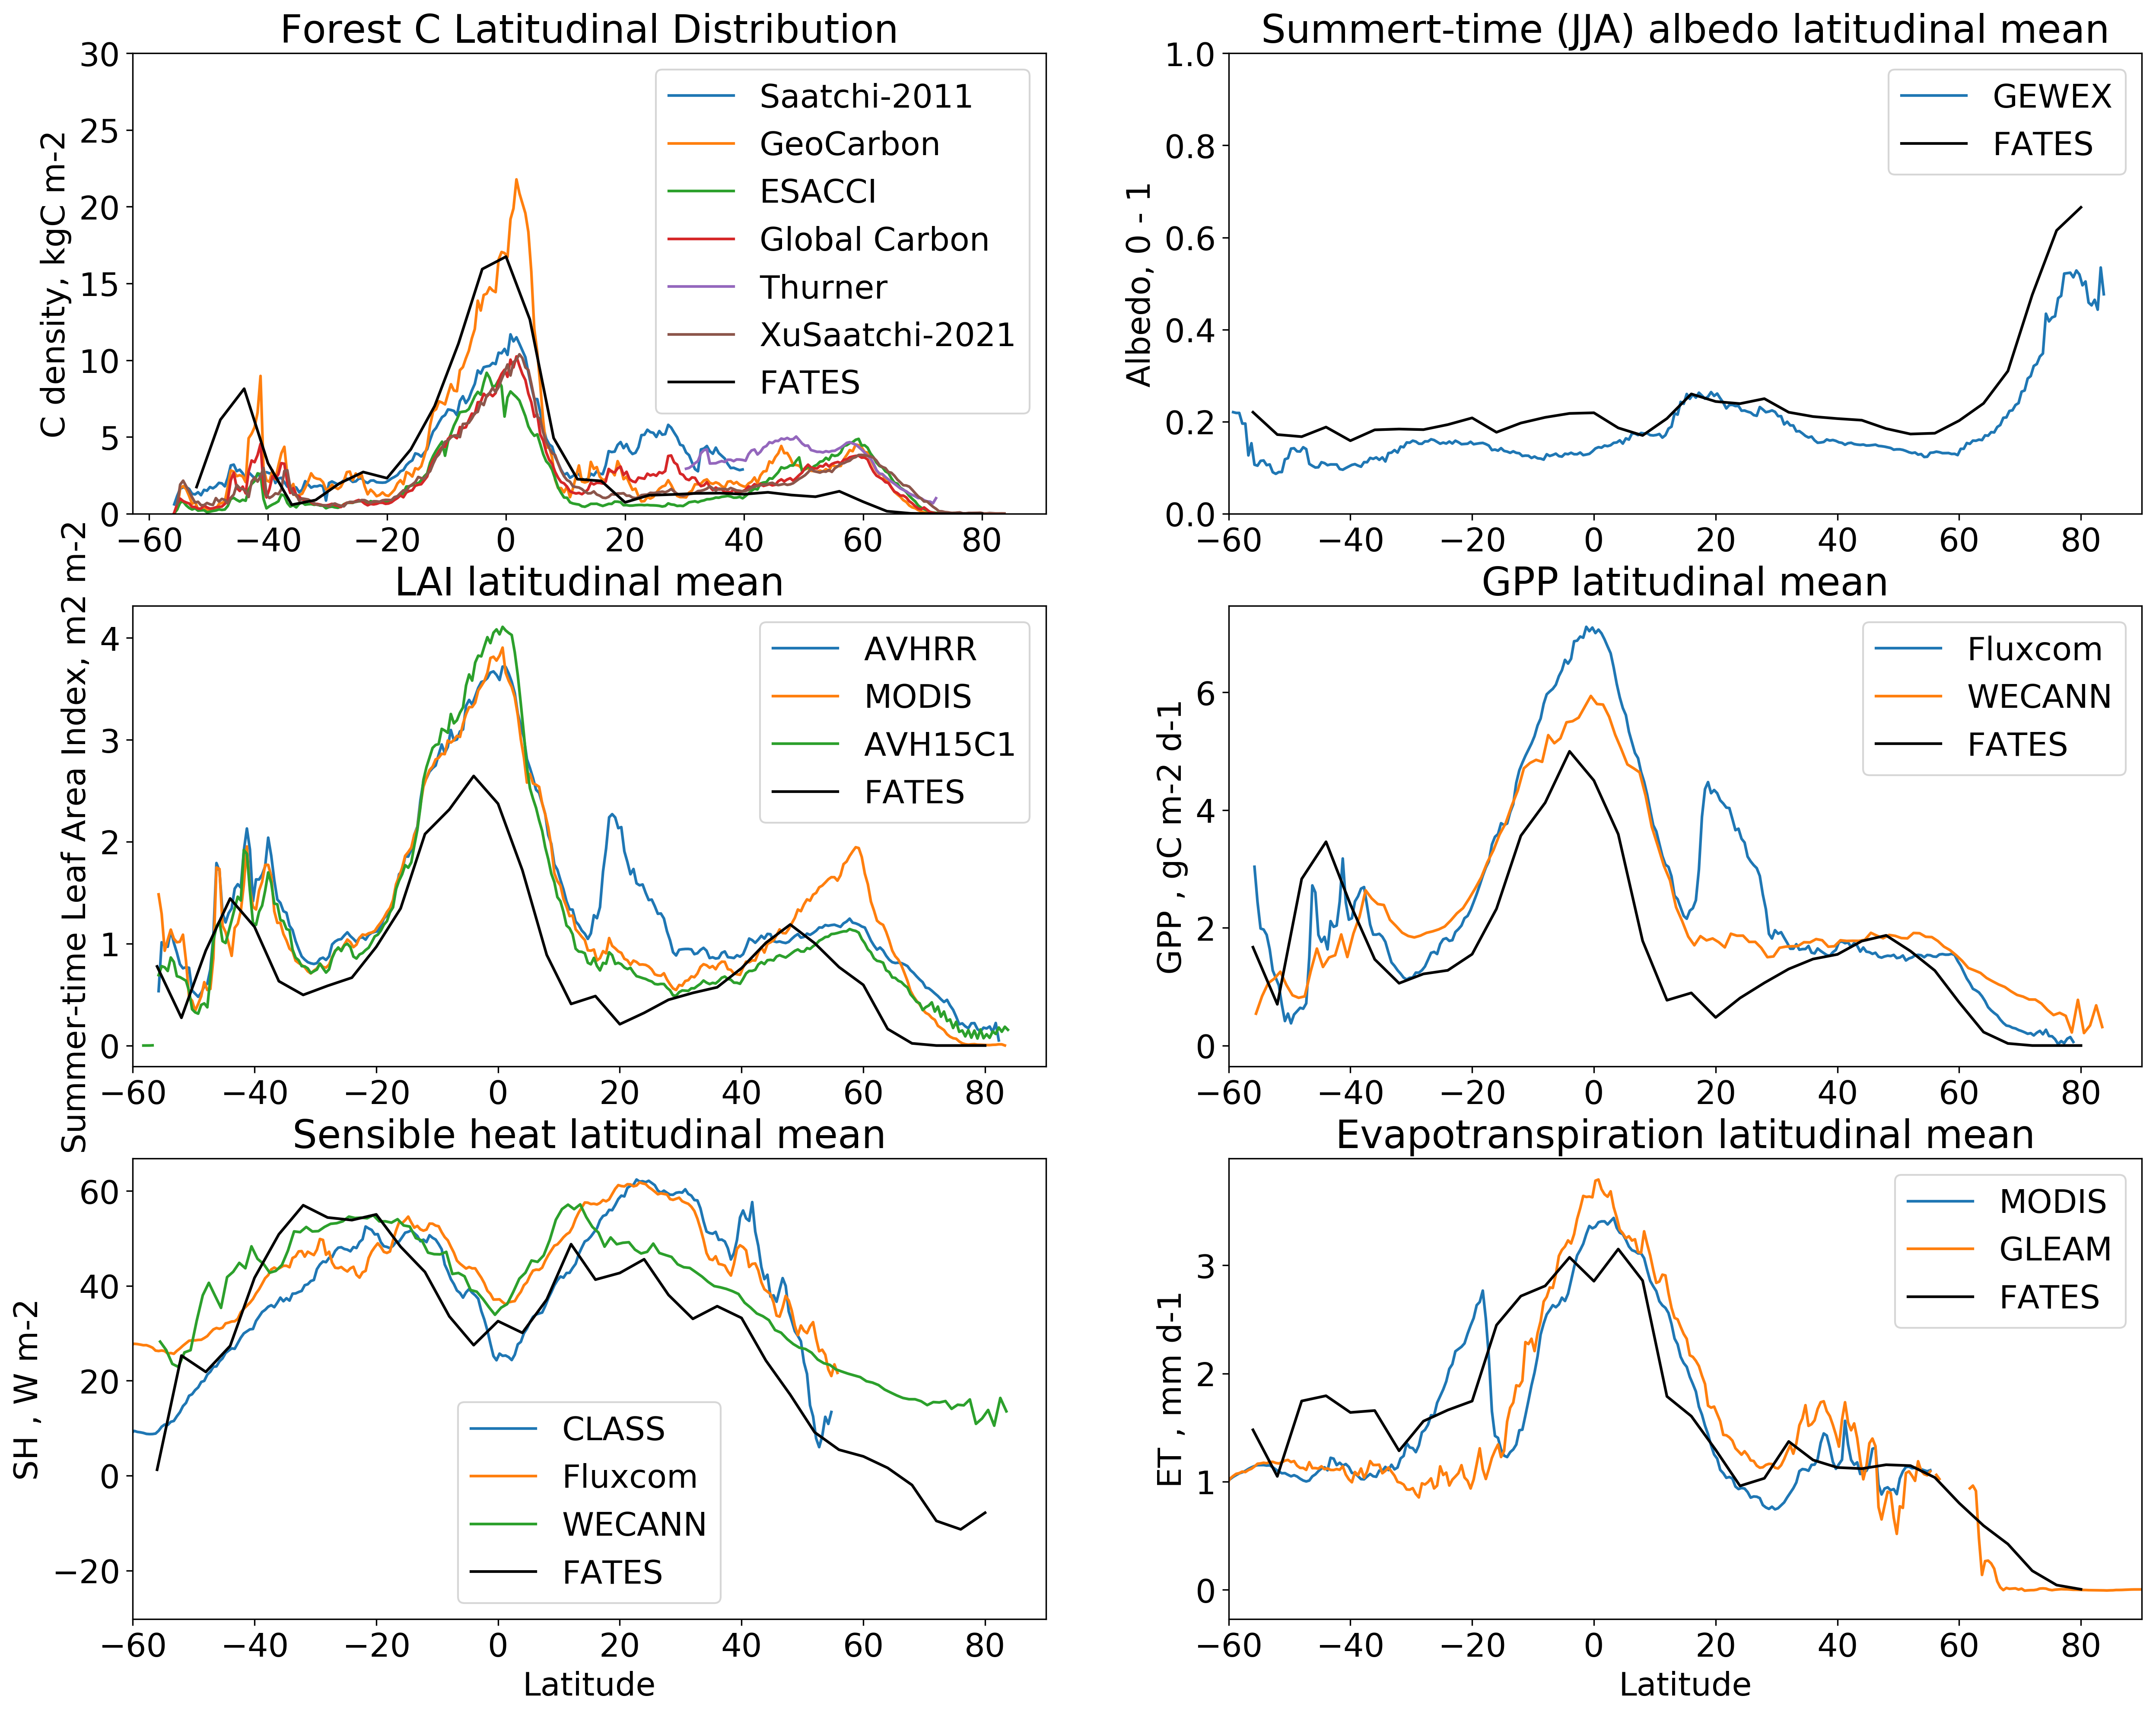

In [17]:
# Combined figure
fig = plt.figure(figsize=(20,16), dpi=300)

plt.rcParams.update({'font.size': 18})

ax1 = fig.add_subplot(321)
# Biomass C density
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
x4 = np.arange(90.25, -89.75, -0.5)
x5 = np.arange(83.75, -56.75, -0.5)
ax1.plot(x1, tropical_lat)
# Here 0.1 is the transfer factor of the unit: Mg/ha -> kg/m2.
ax1.plot(x5, geocarbon_lat*0.1)
ax1.plot(x2, esacci_lat*0.1)
ax1.plot(x1, gc_lat)
ax1.plot(x1, thurner_lat)
ax1.plot(x4, xusaatchi_lat*0.1)
ax1.plot(x3, vegc_for_lat, 'k-')
ax1.legend(['Saatchi-2011', 'GeoCarbon', 'ESACCI', 'Global Carbon', 'Thurner', 'XuSaatchi-2021', 'FATES'])
ax1.set_title('Forest C Latitudinal Distribution')
# ax1.set_xlabel('Latitude')
ax1.set_ylabel('C density, kgC m-2')
# plt.yscale('log')
ax1.set_ylim([0, 30])

# Albedo
ax2 = fig.add_subplot(322)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
x3 = np.arange(89.75, -90.25, -0.5)
ax2.plot(x1, gewex_alb_lat)
ax2.plot(x2, alb_lat, 'k-')
ax2.legend(['GEWEX', 'FATES'])
ax2.set_title('Summert-time (JJA) albedo latitudinal mean')
# ax2.set_xlabel('Latitude')
ax2.set_ylabel('Albedo, 0 - 1')
ax2.set_xlim([-60, 90])
ax2.set_ylim([0, 1])

# LAI
ax3 = fig.add_subplot(323)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-92, 92, 4)
ax3.plot(x1, avhrr_lai_lat)
ax3.plot(x1, modis_lai_lat)
ax3.plot(x1, avh15c1_lai_lat)
ax3.plot(x2, lai_lat, 'k-')
ax3.legend(['AVHRR', 'MODIS', 'AVH15C1', 'FATES'])
ax3.set_title('LAI latitudinal mean')
# ax3.set_xlabel('Latitude')
ax3.set_ylabel('Summer-time Leaf Area Index, m2 m-2')
ax3.set_xlim([-60, 90])

# GPP
ax4 = fig.add_subplot(324)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax4.plot(x1, fluxcom_gpp_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
ax4.plot(x4, wecann_gpp_lat)
ax4.plot(x2, gpp_lat*1000.0*3600.0*24.0, 'k-')
ax4.legend(['Fluxcom', 'WECANN', 'FATES'])
ax4.set_title('GPP latitudinal mean')
# ax4.set_xlabel('Latitude')
ax4.set_ylabel('GPP , gC m-2 d-1')
ax4.set_xlim([-60, 90])

# SH
ax5 = fig.add_subplot(325)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax5.plot(x1, class_hfss_lat)
ax5.plot(x1, fluxcom_hfss_lat)
# plt.plot(x3, fluxnet2015_gpp_lat)
ax5.plot(x4, wecann_hfss_lat)
ax5.plot(x2, hfss_lat, 'k-')
ax5.legend(['CLASS', 'Fluxcom', 'WECANN', 'FATES'])
ax5.set_title('Sensible heat latitudinal mean')
ax5.set_xlabel('Latitude')
ax5.set_ylabel('SH , W m-2')
ax5.set_xlim([-60, 90])

# ET
ax6 = fig.add_subplot(326)
x1 = np.arange(89.75, -90.25, -0.5)
x3 = np.arange(-63.75, 80.25, 0.5)
x4 = np.arange(89.5, -90.5, -1.0)
x2 = np.arange(-92, 92, 4)
ax6.plot(x1, modis_et_lat*3600*24.0)
ax6.plot(x1, gleam_et_lat*3600*24.0)
ax6.plot(x2, et_lat*3600*24.0, 'k-')
ax6.legend(['MODIS', 'GLEAM', 'FATES'])
ax6.set_title('Evapotranspiration latitudinal mean')
ax6.set_xlabel('Latitude')
ax6.set_ylabel('ET , mm d-1')
ax6.set_xlim([-60, 90])

plt.savefig('Fig3_FATES_comparison_obs.png')

In [ ]:
# Block for test